# CLUSTERING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# we are using the scipy implementation
%matplotlib inline
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('data/augmented_data.csv')

df = df.drop(df.index[658])

In [3]:
df.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,lang,...,utc_offset,is_translator,follow_request_sent,protected,verified,notifications,description,contributors_enabled,following,created_at
0,3098421349,Chem-DrySimcoeCounty,cdsimcoecounty,1797,272,920,86,5,https://t.co/l7eYicLoIA,en,...,NaN,False,False,False,False,False,Carpet and Upholstery Cleaning Service,False,False,2015-03-19 22:14:20
1,554067867,tammy jones,tammylou01,5715,35,1651,2898,18,NaN,en,...,NaN,False,False,False,False,False,"Building Praxis to support high impact, high g...",False,False,2012-04-15 01:54:24
2,256597786,Don Hyon,quest4C,1191,170,476,10,3,NaN,en,...,-25200.0,False,False,False,False,False,NaN,False,False,2011-02-23 17:35:04
3,103351486,Anthony Saucedo,ParaHunts_,6525,186,146,55,4,http://t.co/IxM4mCFzbb,en,...,-25200.0,False,False,False,False,False,Lead Investigator of ParaHunts,False,False,2010-01-09 19:13:40
4,199973582,Kathy Staples,kathyscrafts,77757,1474,1554,2,22,http://t.co/gZtuycH1zv,en,...,NaN,False,False,False,False,False,"I make handcrafted Pillows, blankets and more....",False,False,2010-10-08 04:22:13


In [4]:
for a in df.columns:
    print(a)

id
name
screen_name
statuses_count
followers_count
friends_count
favourites_count
listed_count
url
lang
time_zone
location
default_profile
default_profile_image
geo_enabled
profile_image_url
profile_use_background_image
profile_background_image_url_https
profile_text_color
profile_image_url_https
profile_sidebar_border_color
profile_background_tile
profile_sidebar_fill_color
profile_background_image_url
profile_background_color
profile_link_color
utc_offset
is_translator
follow_request_sent
protected
verified
notifications
description
contributors_enabled
following
created_at


## PREPROCESSING

In [5]:
# convert strings to bool, then to int

def str2bool(s):
    if s == 'True':
        return int(True)
    else:
        return int(False)

In [6]:
# replace each name/screen name with its lenght
df['name'] = df['name'].apply(lambda x: len(x))
df['screen_name'] = df['screen_name'].apply(lambda x: len(x))


# replace url with a boolean value
df['url'] = df['url'].apply(lambda x: pd.isnull(x))#delete url and colors features

df = df.drop('id', axis=1)
df = df.drop('profile_image_url', axis=1)
df = df.drop('profile_background_image_url_https', axis=1)
df = df.drop('profile_text_color', axis=1)
df = df.drop('profile_image_url_https', axis=1)
df = df.drop('profile_sidebar_border_color', axis=1)
df = df.drop('profile_sidebar_fill_color', axis=1)
df = df.drop('profile_background_image_url', axis=1)
df = df.drop('profile_background_color', axis=1)
df = df.drop('profile_link_color', axis=1)
df = df.drop('utc_offset', axis=1)


# convert created_at string to int
df['created_at'] = df['created_at'].apply(lambda x: int(x[0:4]))


# replace boolean values with int values
df['url'] = df['url'].apply(lambda x: int(x))
df['default_profile'] = df['default_profile'].apply(lambda x: str2bool(x))
df['default_profile_image'] = df['default_profile_image'].apply(lambda x: str2bool(x))
df['geo_enabled'] = df['geo_enabled'].apply(lambda x: str2bool(x))
df['profile_use_background_image'] = df['profile_use_background_image'].apply(lambda x: str2bool(x))
df['profile_background_tile'] = df['profile_background_tile'].apply(lambda x: str2bool(x))
df['is_translator'] = df['is_translator'].apply(lambda x: str2bool(x))
df['follow_request_sent'] = df['follow_request_sent'].apply(lambda x: str2bool(x))
df['protected'] = df['protected'].apply(lambda x: str2bool(x))
df['verified'] = df['verified'].apply(lambda x: str2bool(x))
df['notifications'] = df['notifications'].apply(lambda x: str2bool(x))
df['contributors_enabled'] = df['contributors_enabled'].apply(lambda x: str2bool(x))
df['following'] = df['following'].apply(lambda x: str2bool(x))

#convert strings to int
df['statuses_count'] = df['statuses_count'].apply(lambda x: int(x))
df['followers_count'] = df['followers_count'].apply(lambda x: int(x))
df['friends_count'] = df['friends_count'].apply(lambda x: int(x))
df['favourites_count'] = df['favourites_count'].apply(lambda x: int(x))
df['listed_count'] = df['listed_count'].apply(lambda x: int(x))

In [7]:
#new experiments

df['delta_follower'] = abs(df['followers_count'] - df['friends_count'])
df = df.drop('friends_count', axis=1)

In [8]:
# one hot encoding
df1 = pd.get_dummies(df.time_zone, dummy_na=True, prefix_sep='time_zone_')
df2 = pd.get_dummies(df.lang, dummy_na=True, prefix_sep='lang_')
df3 = pd.get_dummies(df.location, dummy_na=True, prefix_sep='loc_')

# avoid NaN in columns' names
df1.columns = df1.columns.fillna('no_timezone')
df2.columns = df2.columns.fillna('no_language')
df3.columns = df3.columns.fillna('no_location')

# stack df and one hot encodings
df_one_hot = pd.concat([df1,df2,df3], axis=1)

In [9]:
# tf-idf on description
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
tf_idf = v.fit_transform(df['description'].values.astype('U'))
tf_idf_df = pd.DataFrame(data=tf_idf.toarray(), index=df.index, dtype=np.int8)

In [10]:
# drop one encoded columns from intial df
df = df.drop('time_zone', axis=1)
df = df.drop('lang', axis=1)
df = df.drop('location', axis=1)
df = df.drop('description', axis=1)

# stack dataframes
df_final = pd.concat([df, df_one_hot, tf_idf_df], axis=1)

## Hierarchical

In [11]:
z = linkage(df_final, 'single')
z.shape

(747, 4)

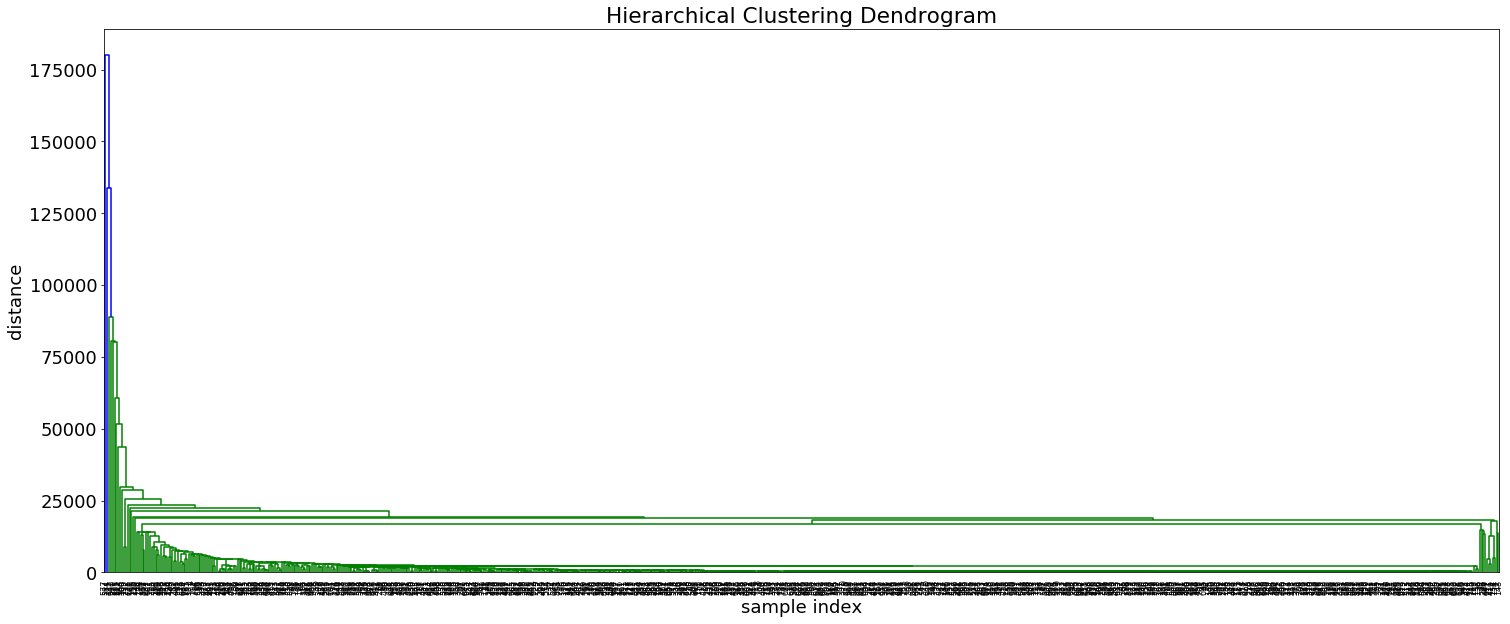

In [12]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(z, 
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

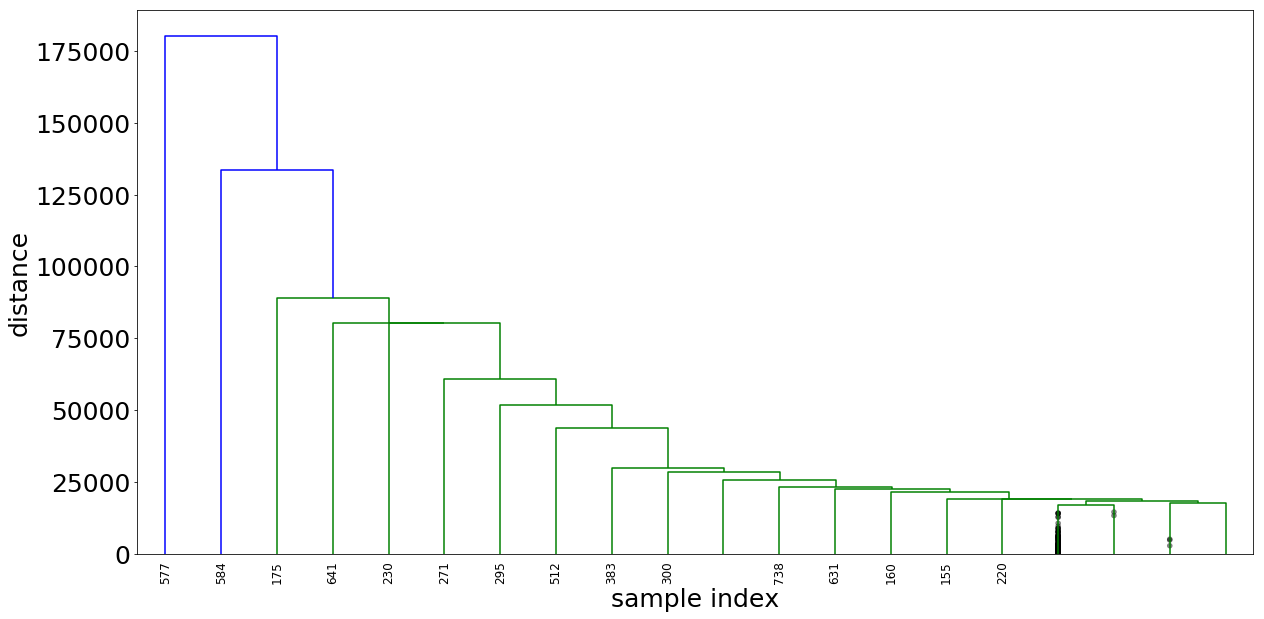

In [38]:
#plt.title('Hierarchical Clustering Dendrogram (truncated to the last 20 merged clusters)')
plt.figure(figsize=(20, 10))
font = {'family' : 'sans', 'size'   : 25}
plt.rc('font', **font)
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.savefig('dendogram.jpg', dpi = 'figure', quality = 95)
plt.show()

In [30]:
wss_values = []
bss_values = []
k_values = range(1,20)

for k in k_values:
    clustering = fcluster(z, k, criterion='maxclust')
    centroids = [np.mean(df_final[clustering==c], axis=0) for c in range(1, k+1)]
    cdist(df_final, centroids, 'euclidean')
    D = cdist(df_final, centroids, 'euclidean')
    cIdx = np.argmin(D, axis=1)
    d = np.min(D, axis=1)

    avgWithinSS = sum(d)/df_final.shape[0]
    
    # Total with-in sum of square
    wss = sum(d**2)

    tss = sum(pdist(df_final)**2)/df_final.shape[0]
    
    bss = tss-wss
    
    wss_values += [wss]
    bss_values += [bss]

<Figure size 432x288 with 0 Axes>

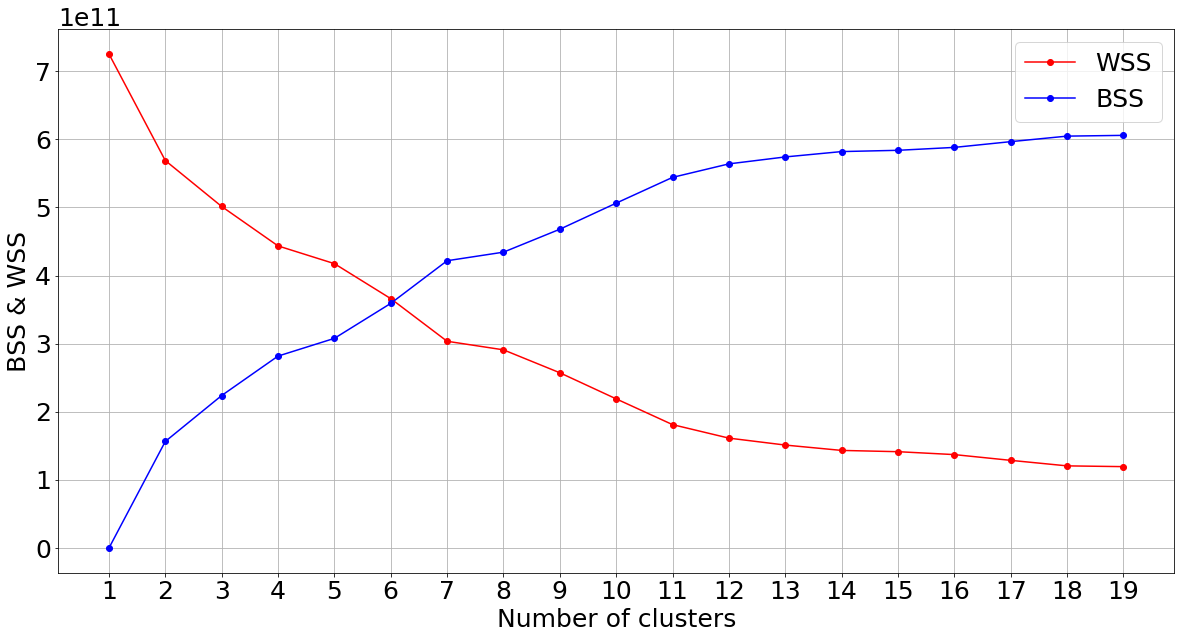

In [39]:
fig = plt.figure()
plt.figure(figsize=(20, 10))
font = {'family' : 'sans', 'size'   : 25}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.legend();
plt.savefig('kneeelbow.jpg', dpi='figure', quality=95)
#plt.title('Hierarchical Clustering')

## K-Means

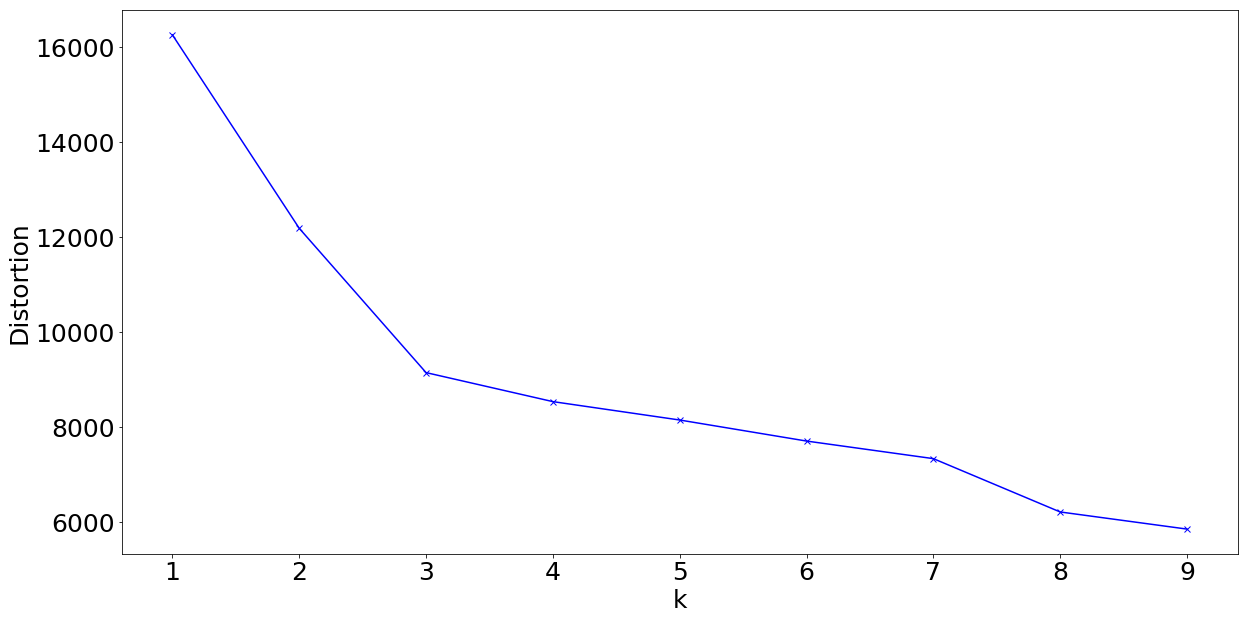

In [40]:
# k means determine k
distortions = []    
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_final)
    distortions.append(sum(np.min(cdist(df_final, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_final.shape[0])

# Plot the elbow
plt.figure(figsize=(20, 10))
font = {'family' : 'sans', 'size'   : 25}
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
#plt.title('The Elbow Method showing the optimal k')
plt.savefig('elbow.jpg', dpi='figure', quality=95)
plt.show()


In [41]:
kmeanModel = KMeans(n_clusters=4)
clusters = kmeanModel.fit_predict(df_final)

In [17]:
df = pd.read_csv('data/augmented_data.csv')

In [51]:
cl1 = np.argwhere(clusters==0).squeeze()
cl2 = np.argwhere(clusters==1).squeeze()
cl3 = np.argwhere(clusters==2).squeeze()
cl4 = np.argwhere(clusters==3).squeeze()

In [52]:
cl1_df = df.iloc[cl1]
cl2_df = df.iloc[cl2]
cl3_df = df.iloc[cl3]
cl4_df = df.iloc[cl4]

In [53]:
cl1_df.shape

(82, 21)

In [54]:
cl2_df.shape

(648, 21)

In [57]:
cl3_df

,name,screen_name,statuses_count,followers_count,favourites_count,listed_count,url,default_profile,default_profile_image,geo_enabled,...,profile_background_tile,is_translator,follow_request_sent,protected,verified,notifications,contributors_enabled,following,created_at,delta_follower
577,11,10,264196,6198,223022,294,1,0,0,0,...,0,0,0,0,0,0,0,0,2015,564
584,11,11,323552,5652,65,258,0,0,0,0,...,0,0,0,0,0,0,0,0,2009,709


In [56]:
cl4_df.shape

(16, 21)